# Описание

Сервис по продаже автомобилей разрабатывает приложение. В нём можно будет быстро узнать рыночную стоимость своего автомобиля. Основная задача проекта: `построить модель для определения стоимости автомобиля`. Условия: `качество предсказания, скорость предсказания и время обучения`. Посмтроеная модель должна быть точной и быстрой!

# Импорт библиотек и загрузка данных

In [1]:
import time
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error as mse, make_scorer
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from tqdm.notebook import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set('notebook', rc={'figure.figsize':(14, 7)})
plt.style.use('seaborn-pastel')

import warnings
warnings.simplefilter("ignore")

In [2]:
df = pd.read_csv('/datasets/autos.csv')

# modified df.isna().sum()
def show_na(df):
    missing_values = df.isna().sum().sort_values(ascending=False)
    missing_percent = df.isna().sum().sort_values(ascending=False) / len(df)
    
    return pd.concat([missing_values, missing_percent], \
                     keys=['Values', 'Percent'], axis=1)


display(df.sample(3), df.describe(), df.shape, show_na(df)) # dataframe info

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
240216,2016-03-17 18:40:17,222,small,1996,manual,55,clio,150000,5,petrol,renault,NaN,2016-03-17 00:00:00,0,16727,2016-03-27 10:17:42
277328,2016-03-12 15:46:21,14900,wagon,2009,auto,205,xc_reihe,150000,6,gasoline,volvo,no,2016-03-12 00:00:00,0,25924,2016-04-07 03:46:17
223794,2016-03-25 13:53:26,7900,wagon,2011,manual,86,ibiza,40000,9,petrol,seat,no,2016-03-25 00:00:00,0,57299,2016-04-05 05:16:26


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


(354369, 16)

,Values,Percent
NotRepaired,71154,0.200791
VehicleType,37490,0.105794
FuelType,32895,0.092827
Gearbox,19833,0.055967
Model,19705,0.055606
LastSeen,0,0.000000
PostalCode,0,0.000000
NumberOfPictures,0,0.000000
DateCreated,0,0.000000
Brand,0,0.000000


# Коротко о проблемах

В категориальных признаках есть пропущенные значения. Эти значения можно заполнить отдельной категорией `"unknown"`. В количественных пропуски отсутствуют. Присутсвуют некорректные данные в признаках `RegistrationYear` и `Power`.
Переменные `DateCrawled`, `DateCreated`, `LastSeen`, можно убрать. В них нет ценной информации для анализа и обучения.

In [3]:
df = df.drop(['DateCrawled', 'DateCreated', 'LastSeen'], axis=1)
df = df.fillna('unknown')

display(df.sample(3))

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,NumberOfPictures,PostalCode
143788,500,small,1994,auto,102,3er,150000,6,petrol,bmw,no,0,31249
262304,6500,wagon,2007,manual,170,a3,150000,7,gasoline,audi,no,0,92521
110275,3590,small,2006,manual,95,forfour,80000,1,petrol,smart,no,0,24941


# Анализ

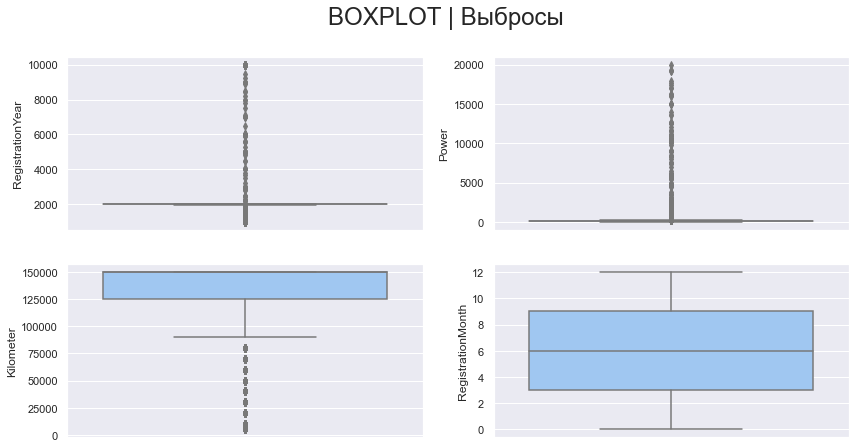

In [4]:
cols = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']

fig, axs = plt.subplots(2, 2, figsize=(14, 7))
axs_lst = [
    axs[0, 0], axs[0, 1],
    axs[1, 0], axs[1, 1],
]

fig.suptitle('BOXPLOT | Выбросы', fontsize=24)

for col, ax in zip(cols, axs_lst):
    sns_ax = sns.boxplot(data=df, y=col, ax=ax)

plt.show()

В признаках `RegistrationYear` и `Power` много неправдоподобных значений. Не очень хорошая новость - эти признаки коррелируют с целевым признаком.

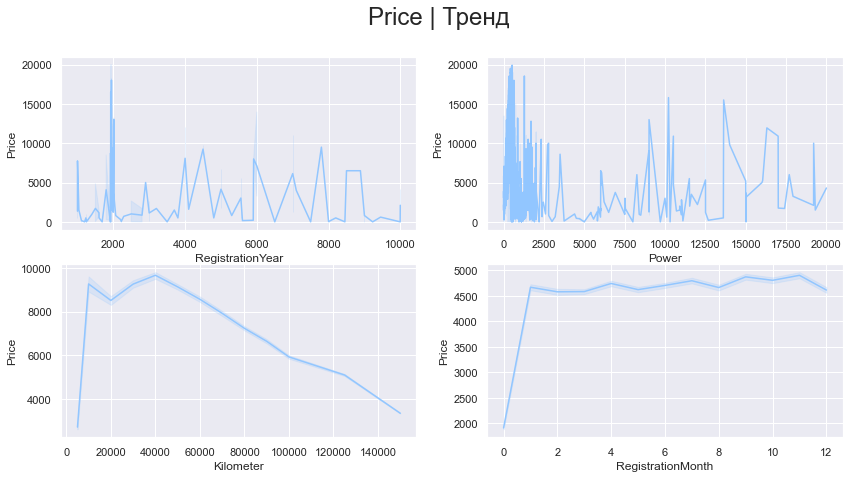

In [5]:
num_cols = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']

fig, axs = plt.subplots(2, 2, figsize=(14, 7))

axs_lst = [
    axs[0, 0], axs[0, 1],
    axs[1, 0], axs[1, 1]
]

fig.suptitle('Price | Тренд', fontsize=24)

for col, ax in zip(num_cols, axs_lst):
    sns.lineplot(x=col, y='Price', data=df, ax=ax)
    
plt.show()

Можно попробовать избавится от выбросов - сделать срез данных по признакам `RegistrationYear` и `Power`. 

По признаку `Kilometer` можно наблюдать рост целевого признака`Price` до 40.000 километров пробега, после чего с ростом пробега целевой признак `Price` уменьшается. 

`Price` почти не реагирует на значения в `RegistrationMonth`.

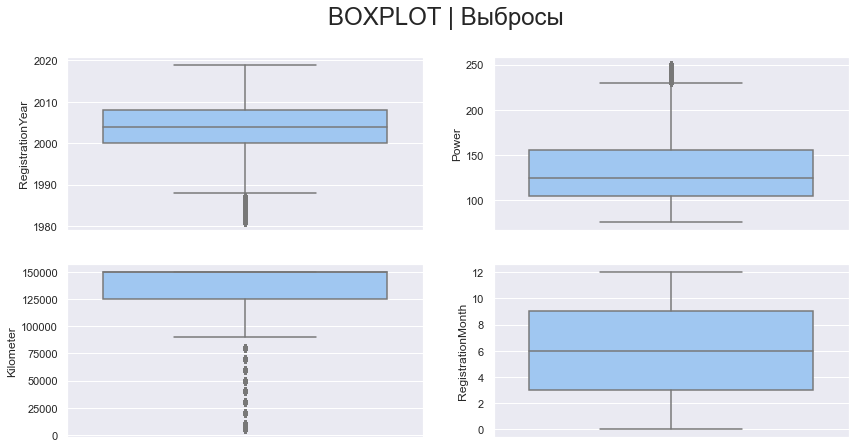

In [6]:
df_prepare = df.loc[
    (df['RegistrationYear'] > 1980) & \
    (df['RegistrationYear'] <= 2019) & \
    (df['Power'] > 75) & \
    (df['Power'] <= 250)
].reset_index(drop=True)


fig, axs = plt.subplots(2, 2, figsize=(14, 7))
axs_lst = [
    axs[0, 0], axs[0, 1],
    axs[1, 0], axs[1, 1],
]

fig.suptitle('BOXPLOT | Выбросы', fontsize=24)

for col, ax in zip(cols, axs_lst):
    sns_ax = sns.boxplot(data=df_prepare, y=col, ax=ax)

plt.show()

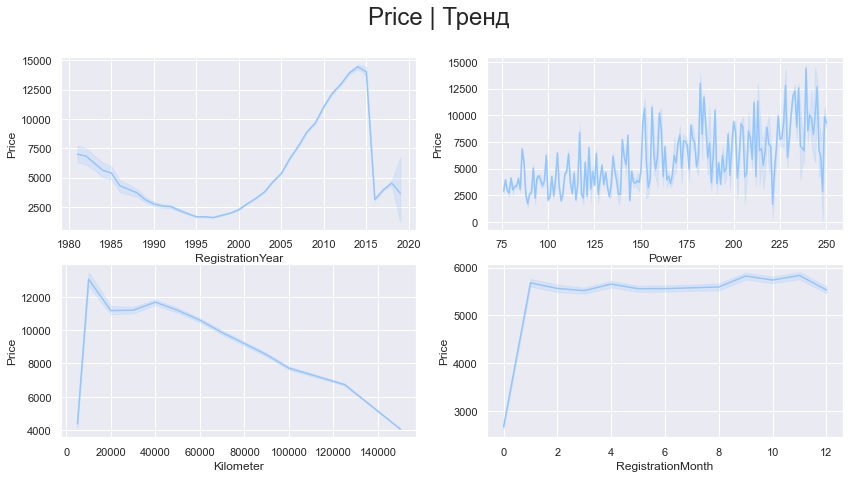

In [7]:
num_cols = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']

fig, axs = plt.subplots(2, 2, figsize=(14, 7))

axs_lst = [
    axs[0, 0], axs[0, 1],
    axs[1, 0], axs[1, 1]
]

fig.suptitle('Price | Тренд', fontsize=24)

for col, ax in zip(num_cols, axs_lst):
    sns.lineplot(x=col, y='Price', data=df_prepare, ax=ax)
    
plt.show()

На графиках без выбросов можно сделать анализ поведения целевого признака `Price` в зависимости от `RegistrationYear` и `Power`.

Чем свежее автомобиль - тем он дороже, это подтверждает график с признаком `RegistrationYear`.

С увеличением признака `Power` можно заметить рост целевого признака `Price`.

# Корреляционная матрица

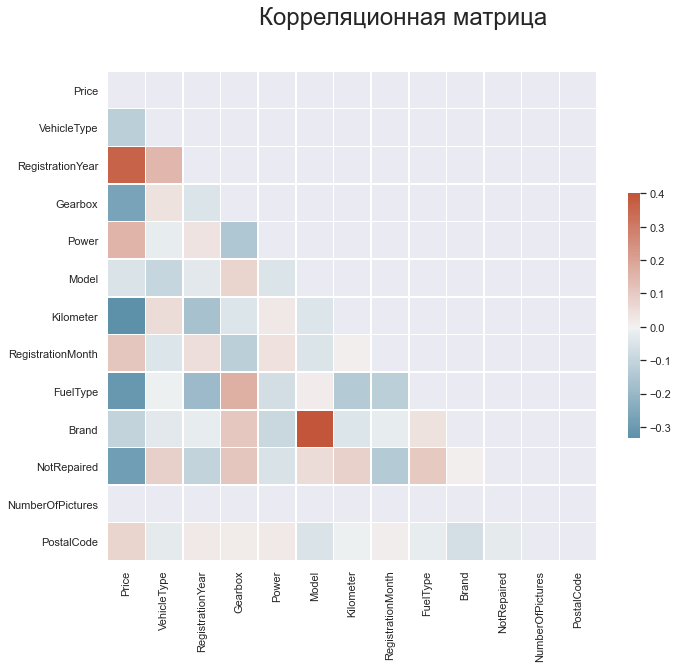

In [8]:
cat_cols = [
    'VehicleType',
    'RegistrationYear',
    'Gearbox',
    'Model',
    'RegistrationMonth',
    'FuelType',
    'Brand',
    'NotRepaired',
    'PostalCode',
    'NumberOfPictures'
]

df_labels = df.copy()
df_labels[cat_cols] = df_labels[cat_cols].astype('category')

enc = LabelEncoder()

for col in cat_cols:
    df_labels[col] = enc.fit_transform(df_labels[col])
    
corr = df_labels.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(11, 9))

fig.suptitle('Корреляционная матрица', fontsize=24)

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.4, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

**Признаки сильно коррелирующие с целевым признаком:**

1. RegistrationYear
2. Gearbox
3. Kilometer
4. FuelType
5. NotRepaired

**Признаки коррелирующие с целевым признаком:**

1. VehicleType
2. Power
3. RegistrationMonth
4. Brand
5. Model

In [9]:
col_to_drop = [
    'PostalCode',
    'NumberOfPictures',
    'Price'
]

# Подготовка данных к обучению

In [10]:
X = df_labels.drop(col_to_drop, axis=1)
y = df_labels['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

print(f'X train/test: {X_train.shape, X_test.shape}')
print(f'y train/test: {y_train.shape, y_test.shape}')

X train/test: ((265776, 10), (88593, 10))
y train/test: ((265776,), (88593,))


In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
def rmse(y, predictions):
    return mse(y, predictions) ** .5

rmse_score = make_scorer(rmse, greater_is_better=False)

# Обучение моделей

In [13]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# LGBMRegressor

In [14]:
estim = LGBMRegressor(boosting_type='gbdt', random_state=42)

params = {
    'n_estimators': [60, 150],
    'num_leaves': [21, 31, 41],
    'learning_rate': np.logspace(-2, 5),
}

grid_lgbm = GridSearchCV(estimator=estim, param_grid=params, cv=cv, \
                         scoring=rmse_score, n_jobs=-1)

In [15]:
%%time
grid_lgbm.fit(X_train, y_train)

Wall time: 11min 21s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': array([1.00000000e-02, 1.38949549e-02, 1.93069773e-02, 2.68269580e-02,
       3.72759372e-02, 5.17947468e-02, 7.19685673e-02, 1.00000000e-01,
       1.38949549e-01, 1.93069773e-01, 2.68269580e-01, 3.72759372e-01,
       5.17947468e-01, 7.1968...
       3.72759372e+02, 5.17947468e+02, 7.19685673e+02, 1.00000000e+03,
       1.38949549e+03, 1.93069773e+03, 2.68269580e+03, 3.72759372e+03,
       5.17947468e+03, 7.19685673e+03, 1.00000000e+04, 1.38949549e+04,
       1.93069773e+04, 2.68269580e+04, 3.72759372e+04, 5.17947468e+04,
       7.19685673e+04, 1.00000000e+05]),
                         'n_estimators': [60, 150],
                         'num_leaves': [21, 31, 41]},
             scoring=make_scorer(rmse, greater_is_better=False))

In [16]:
display(grid_lgbm.best_params_, grid_lgbm.best_score_)

{'learning_rate': 0.2682695795279725, 'n_estimators': 150, 'num_leaves': 41}

-1759.7273340305626

# CatBoostRegressor

In [17]:
estim = CatBoostRegressor(loss_function='RMSE', silent=True, random_state=42)

params = {
    'n_estimators': [60, 150],
}

grid_cb = GridSearchCV(estimator=estim, param_grid=params, cv=cv, \
                       scoring=rmse_score, n_jobs=-1)

In [18]:
%%time
grid_cb.fit(X_train, y_train)

Wall time: 31.1 s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=<catboost.core.CatBoostRegressor object at 0x000001BAE1474BB0>,
             n_jobs=-1, param_grid={'n_estimators': [60, 150]},
             scoring=make_scorer(rmse, greater_is_better=False))

In [19]:
display(grid_cb.best_params_, grid_cb.best_score_)

{'n_estimators': 150}

-1807.268547275044

# Lasso

In [20]:
estim = Lasso(max_iter=150)

params = {
    'alpha': np.logspace(-2, 5)
}

grid_lasso = GridSearchCV(estimator=estim, param_grid=params, cv=cv, \
                       scoring=rmse_score, n_jobs=-1)

In [21]:
%%time
grid_lasso.fit(X_train, y_train)

Wall time: 16.2 s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Lasso(max_iter=150), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-02, 1.38949549e-02, 1.93069773e-02, 2.68269580e-02,
       3.72759372e-02, 5.17947468e-02, 7.19685673e-02, 1.00000000e-01,
       1.38949549e-01, 1.93069773e-01, 2.68269580e-01, 3.72759372e-01,
       5.17947468e-01, 7.19685673e-01, 1.00000000...
       1.00000000e+02, 1.38949549e+02, 1.93069773e+02, 2.68269580e+02,
       3.72759372e+02, 5.17947468e+02, 7.19685673e+02, 1.00000000e+03,
       1.38949549e+03, 1.93069773e+03, 2.68269580e+03, 3.72759372e+03,
       5.17947468e+03, 7.19685673e+03, 1.00000000e+04, 1.38949549e+04,
       1.93069773e+04, 2.68269580e+04, 3.72759372e+04, 5.17947468e+04,
       7.19685673e+04, 1.00000000e+05])},
             scoring=make_scorer(rmse, greater_is_better=False))

In [22]:
display(grid_lasso.best_params_, grid_lasso.best_score_)

{'alpha': 2.6826957952797246}

-3455.1671784231426

# Анализ моделей

In [23]:
models = [
    grid_lgbm.best_estimator_, 
    grid_cb.best_estimator_, 
    grid_lasso.best_estimator_
]

for model in models:
    start = time.time()
    model.fit(X_train, y_train)
    fit_time = time.time() - start
    pred = model.predict(X_test)
    pred_time = time.time() - start
    score = rmse(pred, y_test)
    print(f'Fit time: {fit_time}\nPredict time: {pred_time}\nScore: {score}')
    print()

Fit time: 1.3688328266143799
Predict time: 1.559478521347046
Score: 1753.4126633712233

Fit time: 3.993629217147827
Predict time: 4.009244680404663
Score: 1809.1021428966988

Fit time: 0.06899881362915039
Predict time: 0.06899881362915039
Score: 3514.2432375900253



В ходе проекта были построены и проанализированы три модели - в двух из которых использовался градиентный бустинг. Модель LGBMRegressor является фаворитом по времени обучения, предсказания и оценки RMSE. Для обучения были использованы все данные коррелирующих признаков.